In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error

from keras.callbacks import Callback

import time

In [ ]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
df = df.iloc[:, [0, 1, 2, 4, 3]]
df.head(11)

,Open,High,Low,Volume,Close
Date,,,,,
2006-01-03,47.47,47.85,46.25,7582127,47.58
2006-01-04,47.48,47.73,46.69,7440914,47.25
2006-01-05,47.16,48.20,47.11,5417258,47.65
2006-01-06,47.97,48.58,47.32,6154285,47.87
2006-01-09,46.55,47.10,46.40,8945056,47.08
2006-01-10,46.41,46.75,45.36,9686957,45.65
2006-01-11,45.65,45.70,44.26,8497383,44.93
2006-01-12,44.79,45.09,44.09,5818301,44.36
2006-01-13,44.48,44.85,44.00,4432237,44.40


In [ ]:
df.shape

(3019, 5)

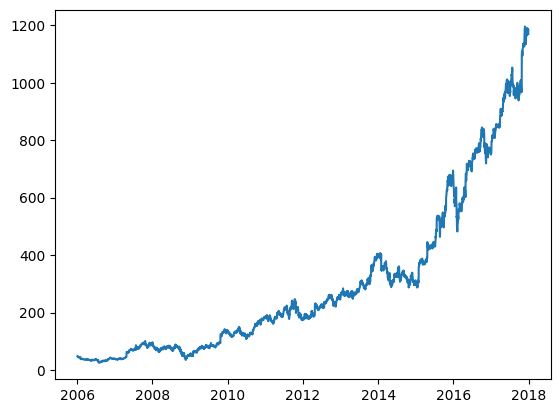

In [ ]:
plt.plot(df.iloc[:, -1])

## TRANSFORMERS

In [ ]:
def create_sequences(df, target_col, exogenous_cols, sequence_length, step):
    sequences = []
    next_values = []
    for i in range(0, len(df) - sequence_length, step):
        seq = df[exogenous_cols + [target_col]].iloc[i : i + sequence_length].values
        label = df[target_col].iloc[i + sequence_length]
        sequences.append(seq)
        next_values.append(label)
    return np.array(sequences), np.array(next_values)

# Example usage
sequence_length = 100
step = 1
target_column = df.columns[-1]
exogenous_column = [] #list(df.columns[:-1])

X, y = create_sequences(df, target_column, exogenous_column, sequence_length, step)

In [ ]:
y

array([  36.07,   34.64,   34.61, ..., 1182.26, 1186.1 , 1169.47])

In [ ]:
N = len(df)
split = int(0.90*N)

In [ ]:
X_train, X_test, y_train, y_test = X[:split-100], X[split-100:], y[:split-100], y[split-100:]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
def positional_encoding(seq_len, model_dim):
    angle_rads = get_angles(
        np.arange(seq_len)[:, np.newaxis],
        np.arange(model_dim)[np.newaxis, :],
        model_dim
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, model_dim):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(model_dim))
    return pos * angle_rates

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    seq_len, model_dim = inputs.shape[1], inputs.shape[2]

    pos_encoding = positional_encoding(seq_len, model_dim)
    inputs += pos_encoding[:, :seq_len, :]

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.25
mlp_dropout = 0.25

In [ ]:
transformer_model = build_model(
    input_shape=(sequence_length, len(exogenous_column)+1),
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout,
)

transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
transformer_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 100, 1)]             0         []                            
                                                                                                  
 tf.math.add_52 (TFOpLambda  (None, 100, 1)               0         ['input_14[0][0]']            
 )                                                                                                
                                                                                                  
 layer_normalization_104 (L  (None, 100, 1)               2         ['tf.math.add_52[0][0]']      
 ayerNormalization)                                                                               
                                                                                           

In [ ]:
start = time.time()

history = transformer_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0,
)

end = time.time()

In [ ]:
mse = transformer_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Validation Set: {mse}")

10/10 [==============================] - 0s 14ms/step - loss: 472.5779
Mean Squared Error on Validation Set: 472.577880859375


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

y_pred = transformer_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MAPE: {mape * 100:.2f}%')
print(f'R^2: {r2}')

10/10 [==============================] - 0s 13ms/step
MAE: 16.147159205556708
MAPE: 1.73%
R^2: 0.9682634184014347


In [ ]:
elapsed_time = end - start
print(f"Time taken for LSTM: {elapsed_time} seconds")

Time taken for LSTM: 152.3158676624298 seconds


10/10 [==============================] - 0s 9ms/step


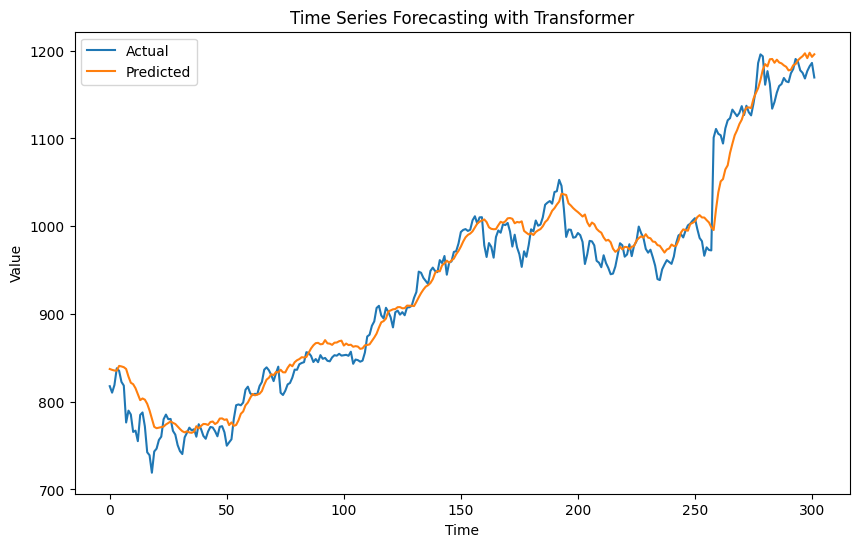

In [ ]:
trainPred = transformer_model.predict(X_train)
testPred = transformer_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual")
plt.plot(testPred, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Forecasting with Transformer")
plt.legend()
plt.show()

In [ ]:
start_point = X_test[-90]

predicted_values = []
current_input = start_point

for _ in range(len(X_test[-90:])):
    current_input_reshaped = current_input.reshape((1, sequence_length, 1))

    next_value = transformer_model.predict(current_input_reshaped)

    predicted_values.append(next_value)

    current_input = np.concatenate([current_input[1:], next_value], axis=0)

predicted_values = np.array(predicted_values).squeeze()

1/1 [==============================] - 0s 20ms/step


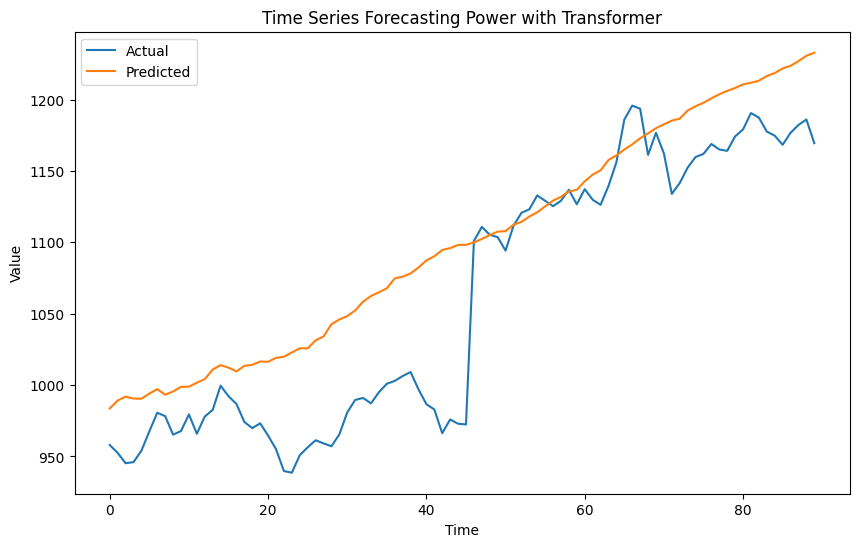

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[-90:], label="Actual")
plt.plot(predicted_values, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Forecasting Power with Transformer")
plt.legend()
plt.show()

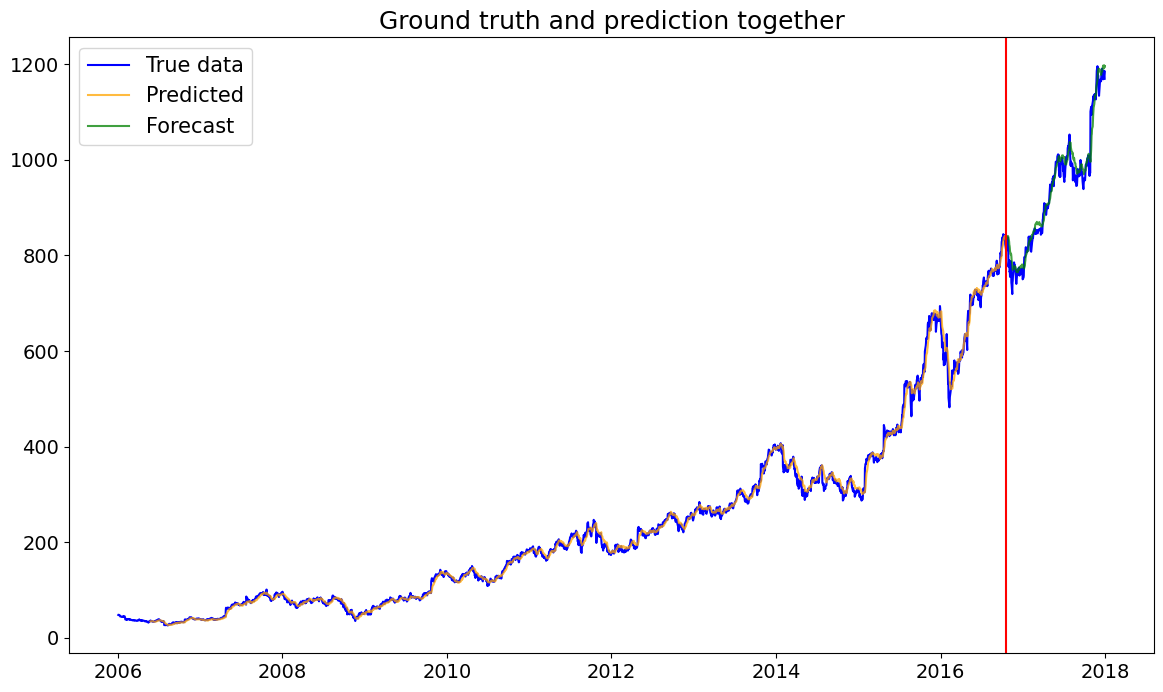

In [ ]:
index = df.index.values
plt.figure(figsize=(14,8))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index, df.iloc[:, -1],c='blue')
plt.plot(index[100:split], trainPred, c='orange', alpha=0.75)
plt.plot(index[split:], testPred, c='green', alpha=0.75)
plt.legend(['True data','Predicted','Forecast'], fontsize=15)
plt.axvline(df.index[split], c="r")
#plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Hyperparameter Analysis

In [ ]:
from itertools import product

dropout_list = [0.0, 0.25, 0.40]
num_heads_list = [4]
lr_list = [0.1, 0.01, 0.001]
epochs_list = [10]

hyperparameters = list(product(dropout_list, num_heads_list, lr_list, epochs_list))

error_train = []
error_test = []

for dout, num_heads, lr, epochs in hyperparameters:
    head_size = 256
    num_heads = num_heads
    ff_dim = 4
    num_transformer_blocks = 4
    mlp_units = [128]
    dropout = dout
    mlp_dropout = dout

    transformer_model = build_model(
    input_shape=(sequence_length, 1),
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout,
    )

    transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")

    history = transformer_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=0,
    )

    ytr_pred = transformer_model.predict(X_train)
    yte_pred = transformer_model.predict(X_test)

    error_train.append(mean_absolute_percentage_error(y_train, ytr_pred))

    error_test.append(mean_absolute_percentage_error(y_test, yte_pred))

10/10 [==============================] - 0s 10ms/step


In [ ]:
hyperparameters

[(0.0, 4, 0.1, 10),
 (0.0, 4, 0.01, 10),
 (0.0, 4, 0.001, 10),
 (0.25, 4, 0.1, 10),
 (0.25, 4, 0.01, 10),
 (0.25, 4, 0.001, 10),
 (0.4, 4, 0.1, 10),
 (0.4, 4, 0.01, 10),
 (0.4, 4, 0.001, 10)]

In [ ]:
error_train

[0.0484411308870767,
 0.04312312778736969,
 0.09737313640082705,
 0.33880092231618336,
 0.04770434821534774,
 0.04535100288456787,
 0.10879455480161808,
 0.18268394741999108,
 0.11402574411310513]

In [ ]:
error_test

[0.023253510514879984,
 0.020297043314433976,
 0.07988651924191868,
 0.30044987903703224,
 0.024066842850478287,
 0.024192849219015652,
 0.14820149172823038,
 0.14566374839061588,
 0.12280068323834208]